# Part 2: boost-histogram plans and Hist

Run the code with us through Binder, altering examples and asking "what if" questions along the way :)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/henryiii/histogram-tutorial/master?filepath=talk_2_bhn_hist.ipynb)

## Boost-histogram numbafication plans

An "event loop" is a programming construct that waits for and dispatches events or messages in a program.  To speed up data analysis for HEP, Scikit-HEP ecosystem is long for a fully Numba-enabled event loop. The awkward and vector portions are mostly developed, leaving the histogramming step as the one element missing from a fully Numba enabled event loop. We plan to enable BH fill from inside the Numba loop without stepping through Python. Currently, we can achieve ([here](https://vector.readthedocs.io/en/latest/usage/structure.html)):

```python
@nb.njit
def compute_masses(awkarray):
    out = np.empty(len(awkarray), np.float64)
    for i, event in enumerate(awkarray):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for vec in event:
            total = total + vec
        out[i] = total.mass
    return out

out = compute_masses(awkarray)
hist.fill(out)
```

Our goal to make this work:

```python
@nb.njit
def compute_masses(hist, awkarray):
    for event in array:
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for vec in event:
            total = total + vec
        hist.fill(total.mass)

compute_masses(hist, awkarray)
```

## Hist

Hist extends boost-histogram with:
* Named axes and labels
* Fancy Jupyter reprs
* UHI+: faster, easier to type indexing additions
* QuickConstruct: a system to reduce the typing when making histograms
* Other useful shortcuts, like density, pandas support, profiles from existing histograms, and more!

### Name shortcuts of Hist

Hist allows names for Boost-histograms axes, the names are unique identifiers in a histogram which are used to support some useful features such as `.fill()` and `.project()`. Specially, hist designs `NamedHist` to provide name shortcuts for the histograms that contain named axes.

In [1]:
import numpy as np
import boost_histogram as bh

from hist import axis, Hist, NamedHist, Stack

# named axes
reg_axis = axis.Regular(10, -3, 3, overflow=False, underflow=False, name="X", label="x [unit]")
var_axis = axis.Variable(range(-5, 6), name="Y", label="y [unit]")
int_axis = axis.Integer(-3, 3, overflow=True, underflow=True, name="Z", label="z [units]")

In [2]:
# histograms with named axes
unnamed_hist = Hist(reg_axis, var_axis, int_axis)
named_hist = NamedHist(reg_axis, var_axis, int_axis)

print("Name of axis 0: \t" + named_hist.axes[0].name + ";")
print("Label of axis 1: \t" + named_hist.axes[1].label + ".")

Name of axis 0: 	X;
Label of axis 1: 	y [unit].


In [3]:
# name shortcuts
unnamed_hist = unnamed_hist.fill(np.random.randn(100), np.random.randn(100), np.random.randn(100))
unnamed_hist_2d = unnamed_hist.project(0, 1)
named_hist = named_hist.fill(X=np.random.randn(100), Y=np.random.randn(100), Z=np.random.randn(100))
named_hist_2d = named_hist.project("X", "Y")

### Repr

Hist has custom reprs when displaying in a Jupyter and supports dark mode.

In [4]:
named_hist_2d.project("X")

test1
test2


NamedHist(Regular(10, -3, 3, underflow=False, overflow=False, name='X', label='x [unit]'), storage=Double()) # Sum: 100.0

In [5]:
named_hist_2d

test1
test2


NamedHist(
  Regular(10, -3, 3, underflow=False, overflow=False, name='X', label='x [unit]'),
  Variable([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], name='Y', label='y [unit]'),
  storage=Double()) # Sum: 100.0

In [6]:
named_hist

test1
test2


NamedHist(
  Regular(10, -3, 3, underflow=False, overflow=False, name='X', label='x [unit]'),
  Variable([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], name='Y', label='y [unit]'),
  Integer(-3, 3, name='Z', label='z [units]'),
  storage=Double()) # Sum: 100.0

Besides the fancy repr, the users can explictly see the data by `.plot()` (using mplhep in the backend) and `.show()` (using histoprint).

### UHI+

Uniform Histogram Indexing (UHI) is one of the most important features of hist, which provides HEP users with handy accessing shortcuts. For example, to access the centroid element of a 2d-histogram, we can:

In [7]:
# boost-histogram UHI
print(unnamed_hist_2d[5, 5])
print(unnamed_hist_2d[{0: 5, 1: 5}])

# hist only
print(unnamed_hist_2d[{"X": 5, "Y": 5}])
print(unnamed_hist_2d[{"X": bh.loc(0), "Y": bh.loc(0)}])
print(unnamed_hist_2d[-1+.8j, 1-.5j])

7.0
7.0
7.0
7.0
7.0


UHI also supports rebin for histograms.

In [8]:
named_hist_2d[:, 1-.5j]

test1
test2


NamedHist(Regular(10, -3, 3, underflow=False, overflow=False, name='X', label='x [unit]'), storage=Double()) # Sum: 31.0

In [9]:
named_hist_2d[0:10:2j, 1-.5j]

test1
test2


NamedHist(Regular(5, -3, 3, underflow=False, overflow=False, name='X', label='x [unit]'), storage=Double()) # Sum: 31.0

### Quick Construct

Besides the standard construction of boost-histogram, hist provides quick construct for HEP users.

In [10]:
unnamed_hist = (
    Hist.new.Reg(50, -3, 3, flow=False)
    .Var(range(-25, 30))
    .Int(-3, 3, flow=True)
    .Double()
)

named_hist = (
    Hist.new.Reg(50, -3, 3, flow=False, name="X", label="x [unit]")
    .Var(range(-25, 30), name="Y", label="y [unit]")
    .Int(-3, 3, flow=True, name="Z", label="z [units]")
    .Double()
)

In [11]:
unnamed_hist.fill(np.random.randn(100), 5*np.random.randn(100), np.random.randn(100)).project(0, 1)

test1
test2


Hist(
  Regular(50, -3, 3, label='Axis 0'),
  Variable(array([-25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.]), label='Axis 1'),
  storage=Double()) # Sum: 100.0

In [12]:
named_hist.fill(X=np.random.randn(100), Y=5*np.random.randn(100), Z=np.random.randn(100)).project("X", "Y")

test1
test2


Hist(
  Regular(50, -3, 3, name='X', label='x [unit]'),
  Variable(array([-25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.]), name='Y', label='y [unit]'),
  storage=Double()) # Sum: 100.0

### Other Shortcuts

Hist also provides some useful shortcuts for HEP analysis. For example, we can get the density of an existing histogram via `.density()`.

In [13]:
named_hist.project("X")[25:30].density()

array([1.25      , 2.08333333, 2.5       , 1.25      , 1.25      ])

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    "results-20210227-133657 - results-20210227-133657.csv",
    usecols=("cpu", "num_downloads", "python_version", "pip_version", "glibc_version", "policy"),
    converters={
        "python_version": str,
        "pip_version": lambda x: int(x.split(".")[0]),
        "glibc_version": lambda x: int(float(x.split("-")[0]) % 1 * 100),
    },
)

pd_hist_4d = Hist.from_columns(
    data,
    ("cpu", "python_version", "pip_version", "policy"),
    weight="num_downloads",
)

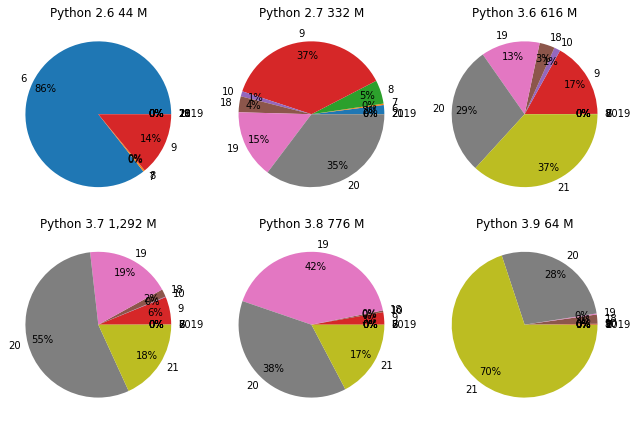

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i, py in enumerate(["2.6", "2.7", "3.6", "3.7", "3.8", "3.9"]):
    ax = axs.flatten()[i]
    ph = pd_hist_4d.project("python_version", "pip_version")[py, :]
    ph.plot_pie(ax=ax, normalize=True, autopct='%1.0f%%', pctdistance=.8)
    ax.set_title(f"Python {py} {int(ph.sum()) // 1000000:,} M")

plt.tight_layout()
plt.show()

In [16]:
xy = np.array([[-2, 1.5], [-2, 1.5], [0.0, -2.0], [0.0, -2.0], [0.0, 0.0], [0.0, 1.0], [1.0, 0.0]])
h = Hist(axis.Regular(3, -3, 3, name="x"), axis.Regular(3, -3, 3, name="y")).fill(*xy.T)
h_profile = h.profile("y")
h.values()

array([[0., 0., 2.],
       [2., 1., 1.],
       [0., 1., 0.]])

In [17]:
h_profile.values()

array([ 2. , -0.5,  0. ])

## Stack implementation

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efb03d3d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efafde880>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efafecdc0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

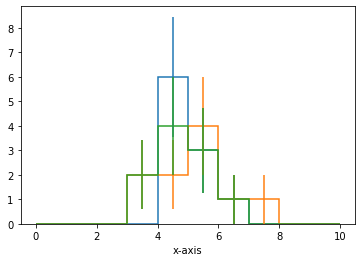

In [18]:
h1 = (Hist.new
    .Reg(10, 0 ,10, name="a", label="x-axis")
    .Int64()
)

h2 = (
    Hist.new
    .Reg(10, 0 ,10, name="a", label="x-axis")
    .Int64()
)

h3 = (
    Hist.new
    .Reg(10, 0 ,10, name="a", label="x-axis")
    .Int64()
)

h1.fill(np.random.normal(5, 1, 10))
h2.fill(np.random.normal(5, 1, 10))
h3.fill(np.random.normal(5, 1, 10))

h4 = Stack(h1, h2, h3)
h4.plot()

Another way to plot is by passing an argument `stack = True`

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efaf804f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efaf94ac0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2efaf2c070>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

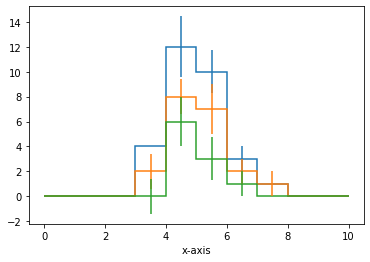

In [19]:
h4.plot(stack = True)

In [ ]:
This argument _stacks_ the histograms one on top of the other as the keyword might suggest. 